In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import tarfile
import pandas as pd
import numpy as np
import igraph as ig
import torch
import numpy as np
import dgl
import tqdm
import sklearn.metrics

In [38]:
df = pd.read_csv("pokec-df-processed2.csv", index_col=0)

In [6]:
edges = pd.read_csv("pokec-edges-processed2.csv", index_col=0)

In [39]:
# фичи и возраст
node_features = df.loc[:, df.columns != 'AGE'].values
node_labels = df.loc[:, df.columns == 'AGE'].values.flatten()
node_features = torch.FloatTensor(node_features)
node_labels = torch.LongTensor(node_labels)

In [40]:
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()

In [41]:
graph = dgl.graph((edges.values[:, 0], edges.values[:, 1]))

In [7]:
with open('train2.txt', 'r') as file:
    train_nids = [int(x) for x in file]
with open('test2.txt', 'r') as file:
    test_nids = [int(x) for x in file]

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, 'mean'))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, 'mean'))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            if l != self.n_layers - 1:
                x = F.relu(x)
        return x

In [11]:
model = SAGE(num_features, 9, num_classes, 2)
model.load_state_dict(torch.load("GraphSAGE_model.pt"))

<All keys matched successfully>

In [12]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
    dataloader = dgl.dataloading.DataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]

                x = input_features[input_nodes]

                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

In [14]:
all_predictions = inference(model, graph, node_features, 8192)
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_mae = sklearn.metrics.mean_absolute_error(test_predictions.numpy(), test_labels.numpy())
print('Test MAE:', test_mae)

100%|██████████| 139/139 [00:01<00:00, 96.69it/s] 

Test MAE: 5.778828559363784


Анализ результатов

In [42]:
result = pd.DataFrame([[int(x) for x in abs(test_predictions - test_labels)], [int(x) for x in test_predictions], [int(x) for x in test_labels]]).T
result.columns = ['abs', 'predict', 'test']

In [43]:
result.index = test_nids

In [44]:
for c in ['completion_percentage', 'gender', 'region', 'last_login', 'completed_level_of_education', 'hight', 'weight']:
    result[c] = df.loc[test_nids][c]

In [45]:
result.sort_values("abs", ascending=False, inplace=True)

In [46]:
result["in_degree"] = list(result.index.map(lambda x : graph.in_degrees(x)))
result["out_degree"] = list(result.index.map(lambda x : graph.out_degrees(x)))

In [48]:
result.head(20)

,abs,predict,test,completion_percentage,gender,region,last_login,completed_level_of_education,hight,weight,in_degree,out_degree
661585,81,18,99,12,1.0,4,0.000937,0,0,0,1,0
368120,81,16,97,12,1.0,1,0.000930,0,0,0,2,4
1064525,81,18,99,12,0.0,164,0.000942,0,0,0,1,0
417129,81,18,99,62,1.0,67,0.000941,1,0,0,23,39
631102,81,18,99,71,0.0,0,0.000942,1,150,42,7,15
156447,80,18,98,12,1.0,184,0.000932,0,0,0,3,3
145205,80,18,98,55,1.0,133,0.000941,1,180,70,18,19
717906,78,19,97,12,1.0,75,0.000940,0,0,0,1,0
601393,77,20,97,71,1.0,80,0.000939,2,175,82,4,9
1044916,76,16,92,12,0.0,105,0.000942,0,0,0,2,2


### Предсказание поколения

In [49]:
def return_generation(age):
    if 2012 - age < 1967:
        return 0 # Поколение беби-бумеров
    if 2012 - age < 1984:
        return 1 # Поколение X
    if 2012 - age < 2000:
        return 2 # Поколение Y, или миллениалы
    if 2012 - age < 2011:
        return 3 # Поколение Z, или зумеры
    else:
        return 4 # Поколение A, или альфа

In [50]:
result["predict_generation"] = result["predict"].apply(lambda x : return_generation(x))

<Axes: xlabel='predict_generation'>

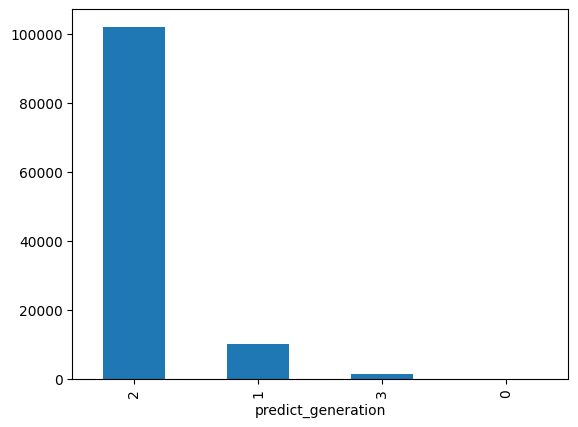

In [52]:
result["predict_generation"].value_counts().plot(kind='bar')

In [53]:
result["test_generation"] = result["test"].apply(lambda x : return_generation(x))

<Axes: xlabel='test_generation'>

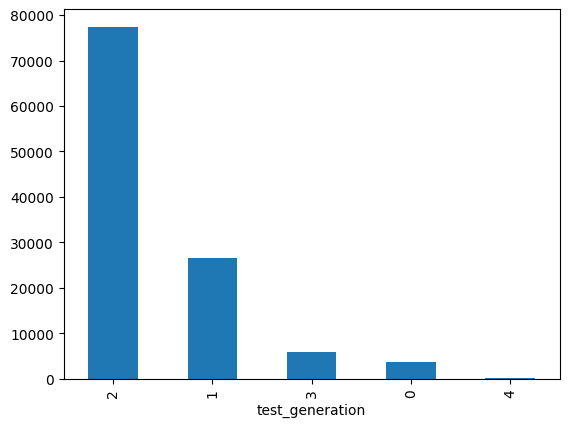

In [55]:
result["test_generation"].value_counts().plot(kind='bar')

In [58]:
print("MAE = ", sklearn.metrics.mean_absolute_error(result["test_generation"], result["predict_generation"]))

MAE =  0.34645295235414175


In [59]:
print("Accuracy = ", sklearn.metrics.accuracy_score(result["test_generation"], result["predict_generation"]))

Accuracy =  0.6834928566401577


"Портреты" людей, на которых модель ошиблась сильнее

большая доля - мужчины

<Axes: ylabel='count'>

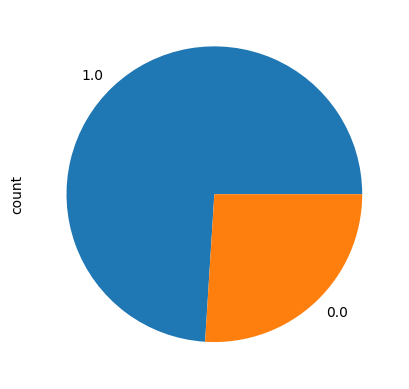

In [68]:
result.iloc[0:50]["gender"].value_counts().plot(kind='pie')

Распределение количество входящих и исходящих ребер

<Axes: xlabel='in_degree'>

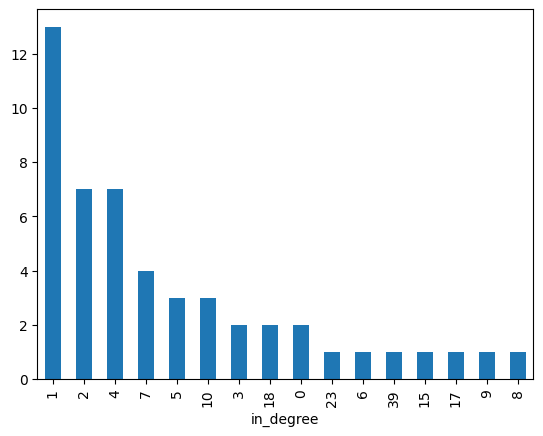

In [74]:
result.iloc[0:50]["in_degree"].value_counts().plot(kind='bar')

<Axes: xlabel='out_degree'>

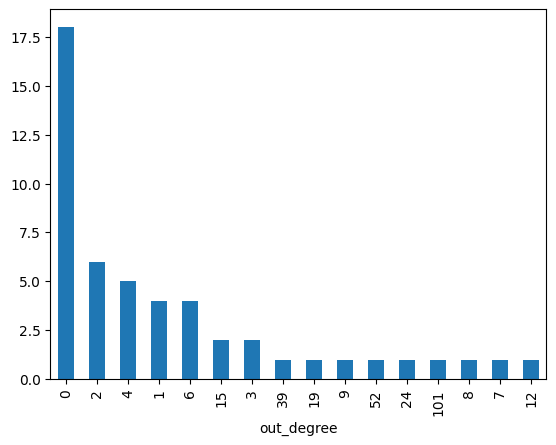

In [76]:
result.iloc[0:50]["out_degree"].value_counts().plot(kind='bar')

Уроверь образования

<Axes: xlabel='completed_level_of_education'>

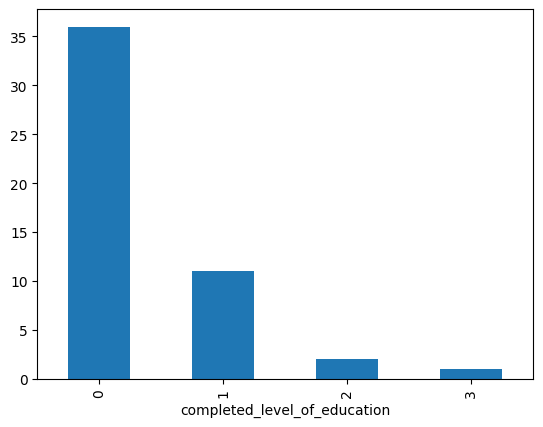

In [78]:
result.iloc[0:50]["completed_level_of_education"].value_counts().plot(kind='bar')

Ошибки в предсказаниях поколений

In [82]:
result["abs_generation"]= [int(x) for x in abs(result["test_generation"] - result["predict_generation"])]

In [88]:
result.sort_values("abs_generation", ascending=False, inplace=False).head(20)

,abs,predict,test,completion_percentage,gender,region,last_login,completed_level_of_education,hight,weight,in_degree,out_degree,predict_generation,test_generation,abs_generation
875998,42,12,54,26,0.0,100,0.000941,0,0,0,5,7,3,0,3
1117044,36,12,48,14,1.0,93,0.000942,0,0,0,2,0,3,0,3
326416,38,12,50,14,1.0,29,0.000942,0,0,0,1,0,3,0,3
1080443,34,12,46,12,1.0,87,0.000942,0,0,0,1,0,3,0,3
857385,43,12,55,12,1.0,90,0.000935,0,0,0,1,1,3,0,3
1054175,28,29,1,12,1.0,22,0.000937,0,0,0,0,1,1,4,3
849640,28,29,1,12,1.0,28,0.000940,0,0,0,0,1,1,4,3
1136110,51,12,63,66,0.0,62,0.000942,1,0,0,1,2,3,0,3
628432,28,29,1,12,1.0,107,0.000937,0,0,0,1,0,1,4,3
936388,28,29,1,12,1.0,7,0.000938,0,0,0,0,14,1,4,3


Абсолютное значение ошибок предсказания и теста:

In [145]:
result[["test_generation", "predict_generation"]].value_counts()

test_generation  predict_generation
2                2                     72424
1                2                     21605
3                2                      5158
1                1                      4796
2                1                      4228
0                2                      2741
                 1                       819
2                3                       788
3                3                       474
                 1                       335
1                3                       207
4                2                        70
0                3                        14
4                1                        10
2                0                         1
3                0                         1
4                3                         1
Name: count, dtype: int64

Относительное:

In [143]:
x = result[["test_generation", "predict_generation"]].value_counts()

In [164]:
res_generation = []
for test_i in range(5):
    for pred_i in range(len(x[test_i].keys())):
        res_generation.append([test_i, x[test_i].keys()[pred_i], x[pred_i].values[pred_i] / result["test_generation"].value_counts()[test_i]])

In [168]:
pd.DataFrame(res_generation, columns=["test_g", "pred_g", "cnt_norm"]).sort_values("cnt_norm", ascending=False, inplace=False)

,test_g,pred_g,cnt_norm
15,4,1,59.209877
14,4,2,33.839506
16,4,3,9.728395
1,0,1,1.341914
11,3,3,0.803619
0,0,2,0.766928
10,3,2,0.459283
2,0,3,0.220481
4,1,1,0.180247
12,3,1,0.132038


Наиболее сильно ошибки модели проявляются между людьми 70+ и ~16

А среди поколений в относительной шкале (относительно количесва наблюдений в тестовой выборке для каждого поколения) -  Поколение альфа с Поколением X, миллениалов и зумеров